# Ajinomoto Study - Pathway 3


In this notebook we demonstrate the use of the Automatic Recommendation Tool (ART) to recommend strain designs for improving dodecanol production using available data for Pathway 3 in Ajinomoto study. We use cycle 1 data to provide recommendations for cycle 2.

First we import the package:

In [1]:
import sys
sys.path.append('../../')

import warning_utils
warning_utils.filter_end_user_warnings()

from IPython.display import HTML

from art.core import RecommendationEngine
from art.utility import load_study
from art import plot
from notebooks.paper import ajinomoto

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### First import the whole study and preprocess the data ###


In [2]:
# Strongly recommended workflow is to *greatly* reduce preprocessing work by loading
# standardized data from the  Experiment Data Depot (EDD, https://pubs.acs.org/doi/10.1021/acssynbio.7b00204).
# To skip the EDD registration step for new ART users & support automated notebook testing,
# load a data file downloaded from EDD instead.
load_from_edd = False

if load_from_edd:
    # Load data from EDD:
    #   * Bespoke data formats from well-meaning collaborators explode in complexity very quickly.
    #   * "Slug" is the final URL portion.  For this study, full URL is https://public-edd.jbei.org/s/ajinomoto/
    edd_study_slug = 'ajinomoto'
    edd_server = 'public-edd.jbei.org'
    df_edd = load_study(edd_study_slug=edd_study_slug,edd_server=edd_server, default_to_system_user=False)
else:
    df_edd = load_study(data_file= '../../data/Ajinomoto.csv')

Preprocessing includes: removing non relevant strains (C0 '9017', 'IPTG' and 'del') from the data set;
adding Cycle number, Strain number, Batch number, Replicate number and Pathway number columns in the dataframe;
combining all replicates and calculating mean and standard deviation;
optimal plotting of gene expression levels ordered for increasing production.

In [3]:
ajinomoto_df, ajinomoto_mean_df = ajinomoto.preprocess(df_edd, plot_flag=False)


/code/notebooks/paper/../../notebooks/paper/ajinomoto.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ajinomoto_df["Pathway"].loc[
/code/notebooks/paper/../../notebooks/paper/ajinomoto.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ajinomoto_df["Pathway"].loc[
/code/notebooks/paper/../../notebooks/paper/ajinomoto.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ajinomoto_df["Pathway"].loc[
/code/notebooks/paper/../../not

In [4]:
ajinomoto_df.head()

,Line Name,Measurement Type,Value,Cycle,Design,Batch,Replicate,Pathway
0,C1_S1_B1.1-R1,dodecan-1-ol,0.72127,1,1,1,1,1
1,C1_S1_B1.1-R1,hexadecan-1-ol,0.03371,1,1,1,1,1
2,C1_S1_B1.1-R1,octadecan-1-ol,0.07051,1,1,1,1,1
3,C1_S1_B1.1-R1,tetradecan-1-ol,0.05971,1,1,1,1,1
4,C1_S1_B1.1-R2,dodecan-1-ol,0.65691,1,1,1,2,1


In [5]:
ajinomoto_mean_df.head()

Measurement Type,A1U2T0,A1U3L3,AHR_ECOLI,"Dodecanoyl-[acyl-carrier-protein] hydrolase, chloroplastic",Fatty acyl-CoA reductase,LCFA_ECOLI,dodecan-1-ol
Design,,,,,,,
1,1400.4,136244.400000,252.6,141483.000000,661.200000,98879.400000,0.655988
2,466.4,151604.200000,469.8,145170.600000,79.200000,113269.000000,0.606746
3,964.0,131395.333333,1660.0,127283.666667,80.666667,353878.333333,0.168947
4,931.0,572420.000000,358.5,115678.500000,676.000000,81778.000000,0.468715
5,0.0,447718.000000,891.0,108267.000000,0.000000,85735.333333,0.539463


### Proceed with the task of maximazing dodecanol production ###

Define ART input parameters:

In [6]:
art_params = {
    'input_vars': [
        'Dodecanoyl-[acyl-carrier-protein] hydrolase, chloroplastic',
        'LCFA_ECOLI',
        'Fatty acyl-CoA reductase',
        'AHR_ECOLI',
    ],
    'response_vars': ['dodecan-1-ol'],
    'objective': 'maximize',
    'threshold': 0.2,
    'verbose': 1,
    'seed': 10,
    'output_dir': '../../results/Dodecanol_P3',
    'cross_val': True,
    'recommend': False,
    'num_recommendations': 10,
    'build_model': False,
    'max_mcmc_cores': 2,
}

In [7]:
# Set Pathway Variant
pathway_variant = 3

df = ajinomoto_df[['Line Name','Measurement Type','Value']].loc[ajinomoto_df['Pathway']==pathway_variant]

# Create Report Heading
title = '<h2>Pathway acr1&yjgB Titer Maximization.<br/>Recommendations for protein expressions provided.</h2>'
display(HTML(title))

In [8]:
art = RecommendationEngine(df=df, **art_params)


Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 12 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.


How many instances/replicates?

In [9]:
len(art.df)


35

How manu unique designs/strains?

In [10]:
designs1 = art.df["Design"].unique().tolist()
len(designs1)

12

How many replicates resulted in no product detected?

In [11]:
product = art.df['Response Variables','dodecan-1-ol']
zero_product1 = product[product==0]
len(zero_product1)


0

## DBTL Cycle 1 ##

Build and evaluate the predictive model

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


ART identified 12 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models…
Fitting L0 models…
Building TPOT models…
Best pipeline: KNeighborsRegressor(RidgeCV(DecisionTreeRegressor(input_matrix, max_depth=7, min_samples_leaf=8, min_samples_split=8)), n_neighbors=3, p=1, weights=distance)
Done fitting L0 models in 31.08 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 20.77 s
Fitting L0 models…
Building TPOT models…
Best pipeline: KNeighborsRegressor(RidgeCV(input_matrix), n_neighbors=9, p=1, weights=distance)
Done fitting L0 models in 20.52 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 19.48 s
Fitting L0 models…
Building TPOT models…
Best pipeline: KNeighborsRegressor(FeatureAgglomeration(KNeighborsRegressor(input_matrix, n_neighbors=2, p=1, weights=distance), affinity=l1, linkage=average), n_neighbors=11, p=2, weights=distance)
Done fitting L0 models in 27.15 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 22.19 s
Fitting L0 models…
Building TPOT models…
Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=9, p=1, weights=distance)
Done fitting L0 models in 3.29 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 17.49 s
Fitting L0 models…
Building TPOT models…
Best pipeline: KNeighborsRegressor(GradientBoostingRegressor(SGDRegressor(RidgeCV(input_matrix), alpha=0.0, eta0=0.1, fit_intercept=False, l1_ratio=0.25, learning_rate=constant, loss=epsilon_insensitive, penalty=elasticnet, power_t=0.0), alpha=0.95, learning_rate=0.5, loss=quantile, max_depth=4, max_features=0.05, min_samples_leaf=8, min_samples_split=3, n_estimators=100, subsample=0.8500000000000001), n_neighbors=9, p=1, weights=distance)
Done fitting L0 models in 39.52 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 23.63 s
Fitting L0 models…
Building TPOT models…
Best pipeline: KNeighborsRegressor(FeatureAgglomeration(input_matrix, affinity=manhattan, linkage=average), n_neighbors=17, p=2, weights=distance)
Done fitting L0 models in 5.13 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 18.05 s
Fitting L0 models…
Building TPOT models…
Best pipeline: ElasticNetCV(Nystroem(Nystroem(input_matrix, gamma=1.0, kernel=additive_chi2, n_components=5), gamma=1.0, kernel=cosine, n_components=5), l1_ratio=0.65, tol=1e-05)
Done fitting L0 models in 51.27 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.844554905786627e-07, tolerance: 2.6644932615384617e-07
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7974457343400592e-06, tolerance: 2.6644932615384617e-07
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.22762676393767e-06, tolerance: 2.6644932615384617e-07
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-packa

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 23.47 s
Fitting L0 models…
Building TPOT models…
Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=10, min_samples_leaf=3, min_samples_split=11)
Done fitting L0 models in 3.54 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 15.62 s
Fitting L0 models…
Building TPOT models…
Best pipeline: AdaBoostRegressor(PCA(input_matrix, iterated_power=3, svd_solver=randomized), learning_rate=0.001, loss=exponential, n_estimators=100)
Done fitting L0 models in 4.00 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 14.57 s
Fitting L0 models…
Building TPOT models…
Best pipeline: KNeighborsRegressor(input_matrix, n_neighbors=5, p=2, weights=uniform)
Done fitting L0 models in 51.14 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 23.86 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.063221,271.116528,0.051229,0.006621,-6.313712
Random Forest Regressor,0.024572,152.931252,0.022086,0.001092,-0.205700
Support Vector Regressor,0.034623,214.272780,0.017647,0.001510,-0.668064
Kernel Ridge Regressor,0.029045,154.527924,0.021801,0.001319,-0.456774
K-NN Regressor,0.034011,161.995029,0.022697,0.001672,-0.846783
Gaussian Process Regressor,0.029175,143.020282,0.021281,0.001304,-0.440459
Gradient Boosting Regressor,0.027508,140.747382,0.022890,0.001281,-0.414530
TPOT Regressor,0.020794,90.543698,0.014089,0.000631,0.303158
Ensemble Model,0.022632,115.343803,0.017692,0.000825,0.088480


Done with 10-fold cross-validation in 444.35 s


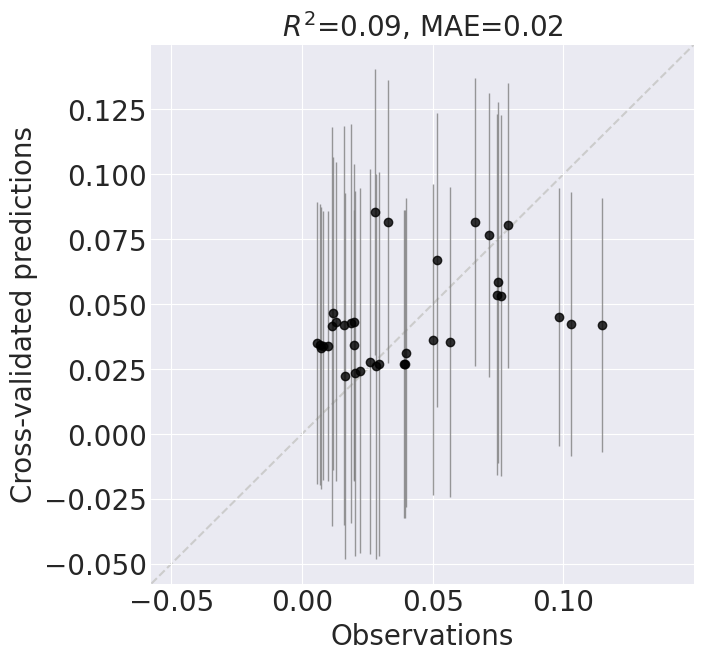

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: KNeighborsRegressor(RidgeCV(input_matrix), n_neighbors=9, p=2, weights=distance)
Done fitting L0 models in 55.78 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 20.92 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.060023,256.995578,0.044701,5.600901e-03,-5.186595
Random Forest Regressor,0.002925,19.460167,0.003115,1.826054e-05,0.979830
Support Vector Regressor,0.032983,211.312692,0.015654,1.332938e-03,-0.472325
Kernel Ridge Regressor,0.017599,88.976943,0.013899,5.028980e-04,0.444513
K-NN Regressor,0.013677,60.942234,0.013026,3.567330e-04,0.605963
Gaussian Process Regressor,0.000578,3.078552,0.000739,8.808461e-07,0.999027
Gradient Boosting Regressor,0.000193,0.865212,0.000136,5.571405e-08,0.999938
TPOT Regressor,0.000000,0.000000,0.000000,0.000000e+00,1.000000
Ensemble Model,0.004388,25.211672,0.002652,2.629048e-05,0.970960


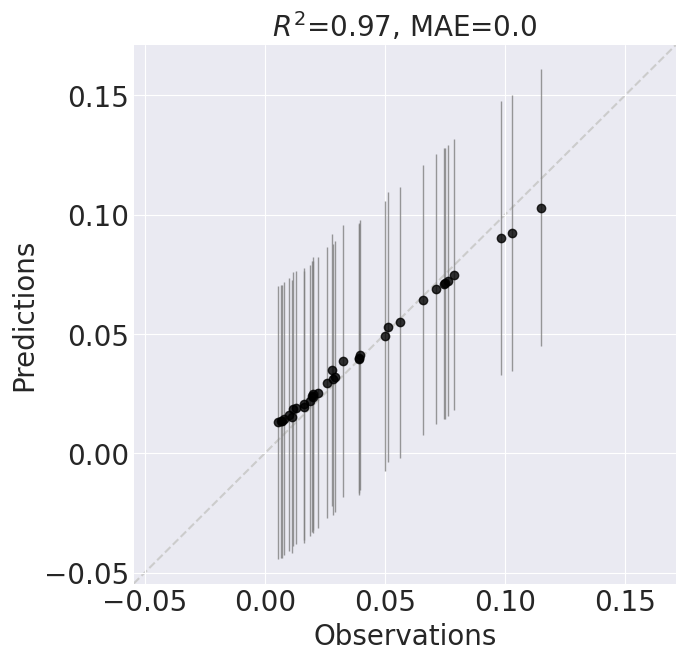

Done building models in 77.74 s


In [12]:
# Run ART
art_params['build_model'] = True
art = RecommendationEngine(df=df, **art_params)


In [13]:
art.evaluate_models()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.060023,256.995578,0.044701,5.600901e-03,-5.186595
Random Forest Regressor,0.002925,19.460167,0.003115,1.826054e-05,0.979830
Support Vector Regressor,0.032983,211.312692,0.015654,1.332938e-03,-0.472325
Kernel Ridge Regressor,0.017599,88.976943,0.013899,5.028980e-04,0.444513
K-NN Regressor,0.013677,60.942234,0.013026,3.567330e-04,0.605963
Gaussian Process Regressor,0.000578,3.078552,0.000739,8.808461e-07,0.999027
Gradient Boosting Regressor,0.000193,0.865212,0.000136,5.571405e-08,0.999938
TPOT Regressor,0.000000,0.000000,0.000000,0.000000e+00,1.000000
Ensemble Model,0.004388,25.211672,0.002652,2.629048e-05,0.970960


In [14]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.063221,271.116528,0.051229,0.006621,-6.313712
Random Forest Regressor,0.024572,152.931252,0.022086,0.001092,-0.205700
Support Vector Regressor,0.034623,214.272780,0.017647,0.001510,-0.668064
Kernel Ridge Regressor,0.029045,154.527924,0.021801,0.001319,-0.456774
K-NN Regressor,0.034011,161.995029,0.022697,0.001672,-0.846783
Gaussian Process Regressor,0.029175,143.020282,0.021281,0.001304,-0.440459
Gradient Boosting Regressor,0.027508,140.747382,0.022890,0.001281,-0.414530
TPOT Regressor,0.020794,90.543698,0.014089,0.000631,0.303158
Ensemble Model,0.022632,115.343803,0.017692,0.000825,0.088480


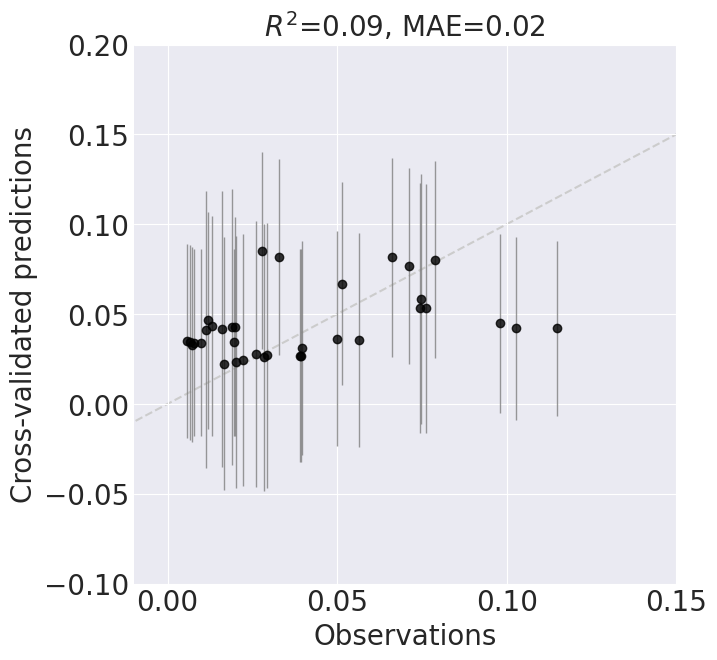

In [15]:
plot.predictions_vs_observations(art, cv=True, error_bars=True,
                                 x_limits=[[-0.01, 0.15]], y_limits=[[-0.1, 0.2]])

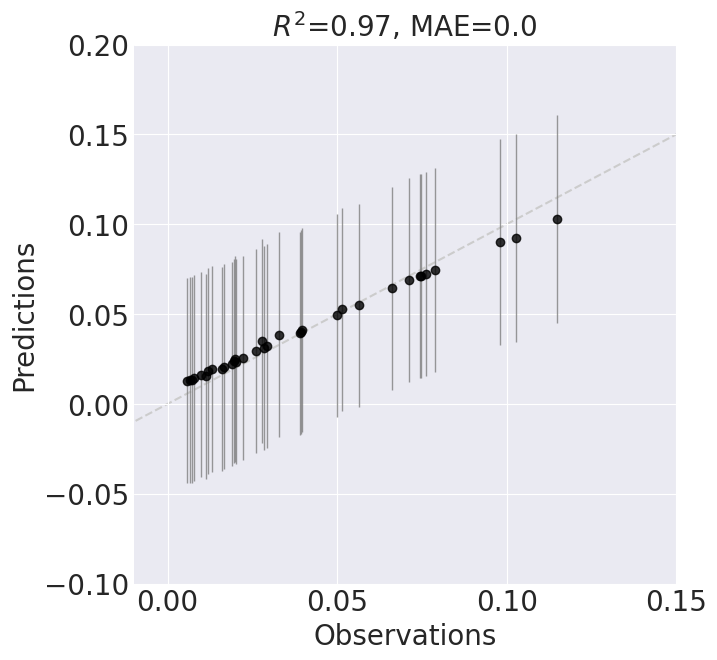

In [16]:
plot.predictions_vs_observations(art, cv=False, error_bars=True,
                                 x_limits=[[-0.01, 0.15]], y_limits=[[-0.1, 0.2]])

In [17]:
%%time
draws = art.generate_recommendation_candidates()


Starting parallel tempering using 2 chains…
Done with parallel tempering in 111.00 s
CPU times: user 46.5 ms, sys: 6.16 ms, total: 52.6 ms
Wall time: 1min 51s


Choosing recommendations (19,800 candidates)…


Done choosing recommendations in 0.02 s


,"Dodecanoyl-[acyl-carrier-protein] hydrolase, chloroplastic",LCFA_ECOLI,Fatty acyl-CoA reductase,AHR_ECOLI,dodecan-1-ol
0,233365.293331,424574.475875,23875.240987,169377.064563,0.088703
1,207890.926222,432023.860853,52049.226064,204687.787432,0.088640
2,232583.131006,389782.213568,41608.071119,209854.765467,0.088252
3,202638.980326,438532.489540,47511.391046,159113.918066,0.087467
4,201532.579856,432975.884381,35324.096037,268414.577341,0.085893
5,235899.170491,410232.904449,26582.972941,222658.514777,0.085657
6,218345.075076,417911.497166,67722.503494,234228.403337,0.085590
7,224208.964016,438748.059941,19351.535252,207164.115295,0.085181
8,197986.886786,424059.565327,53690.142061,258612.139432,0.085112
9,257062.487174,385871.436686,53140.074445,167323.078838,0.085053


Sampling: [y]


Sampling posterior predictive distributions…
Done sampling in 0.73 s


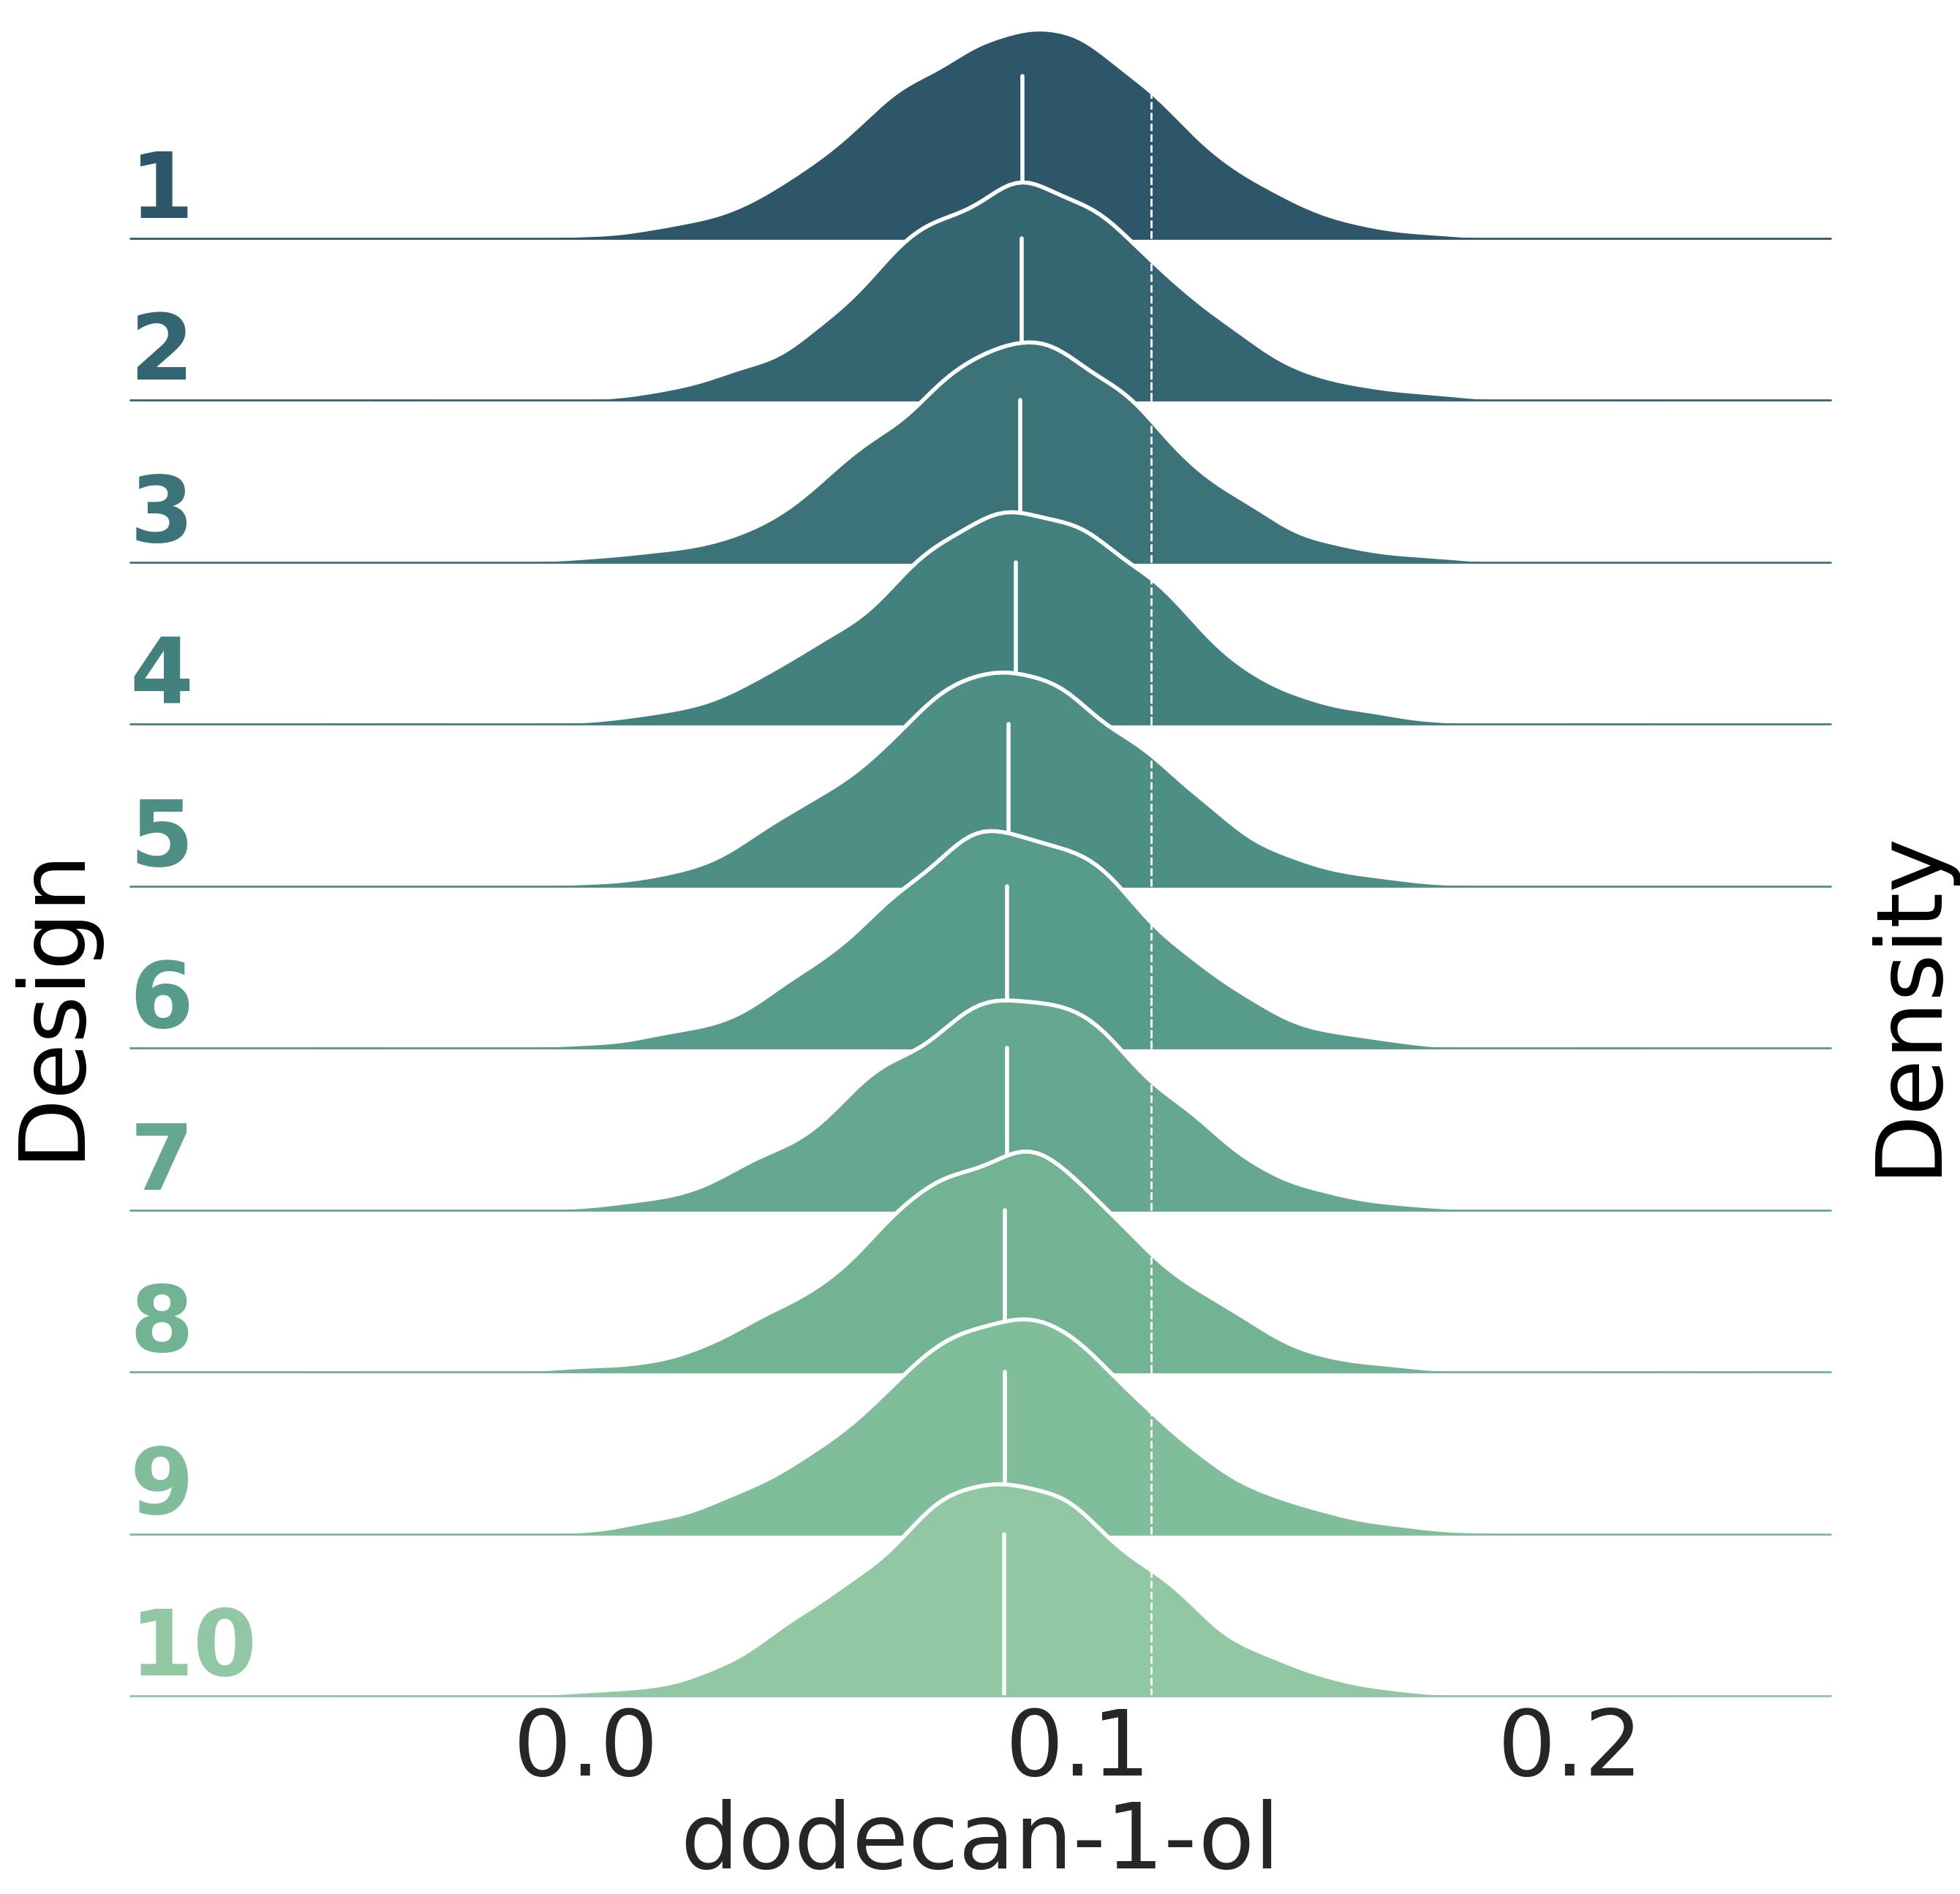

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.73 s
Done computing success probabilities in 0.73 s


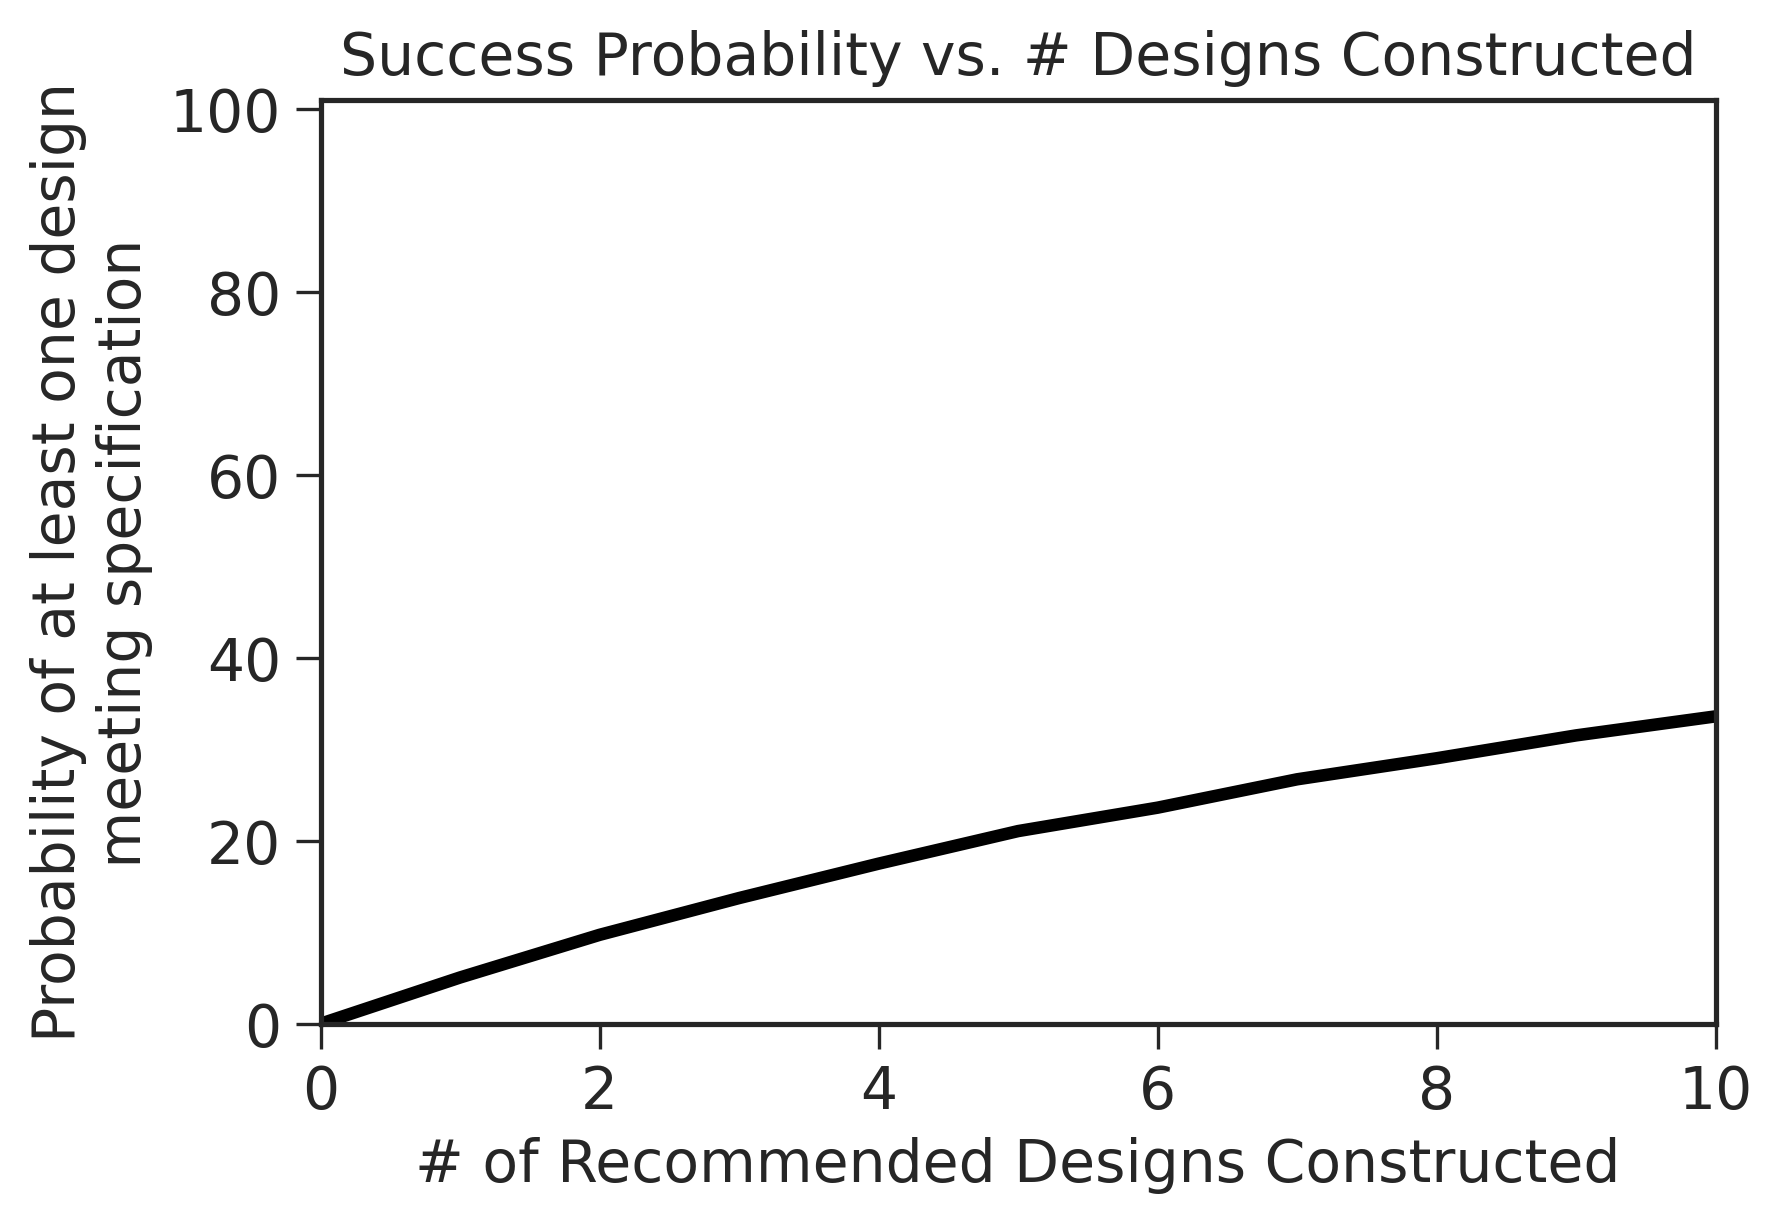

In [18]:
art.select_recommendations(draws)

Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 1.15 s


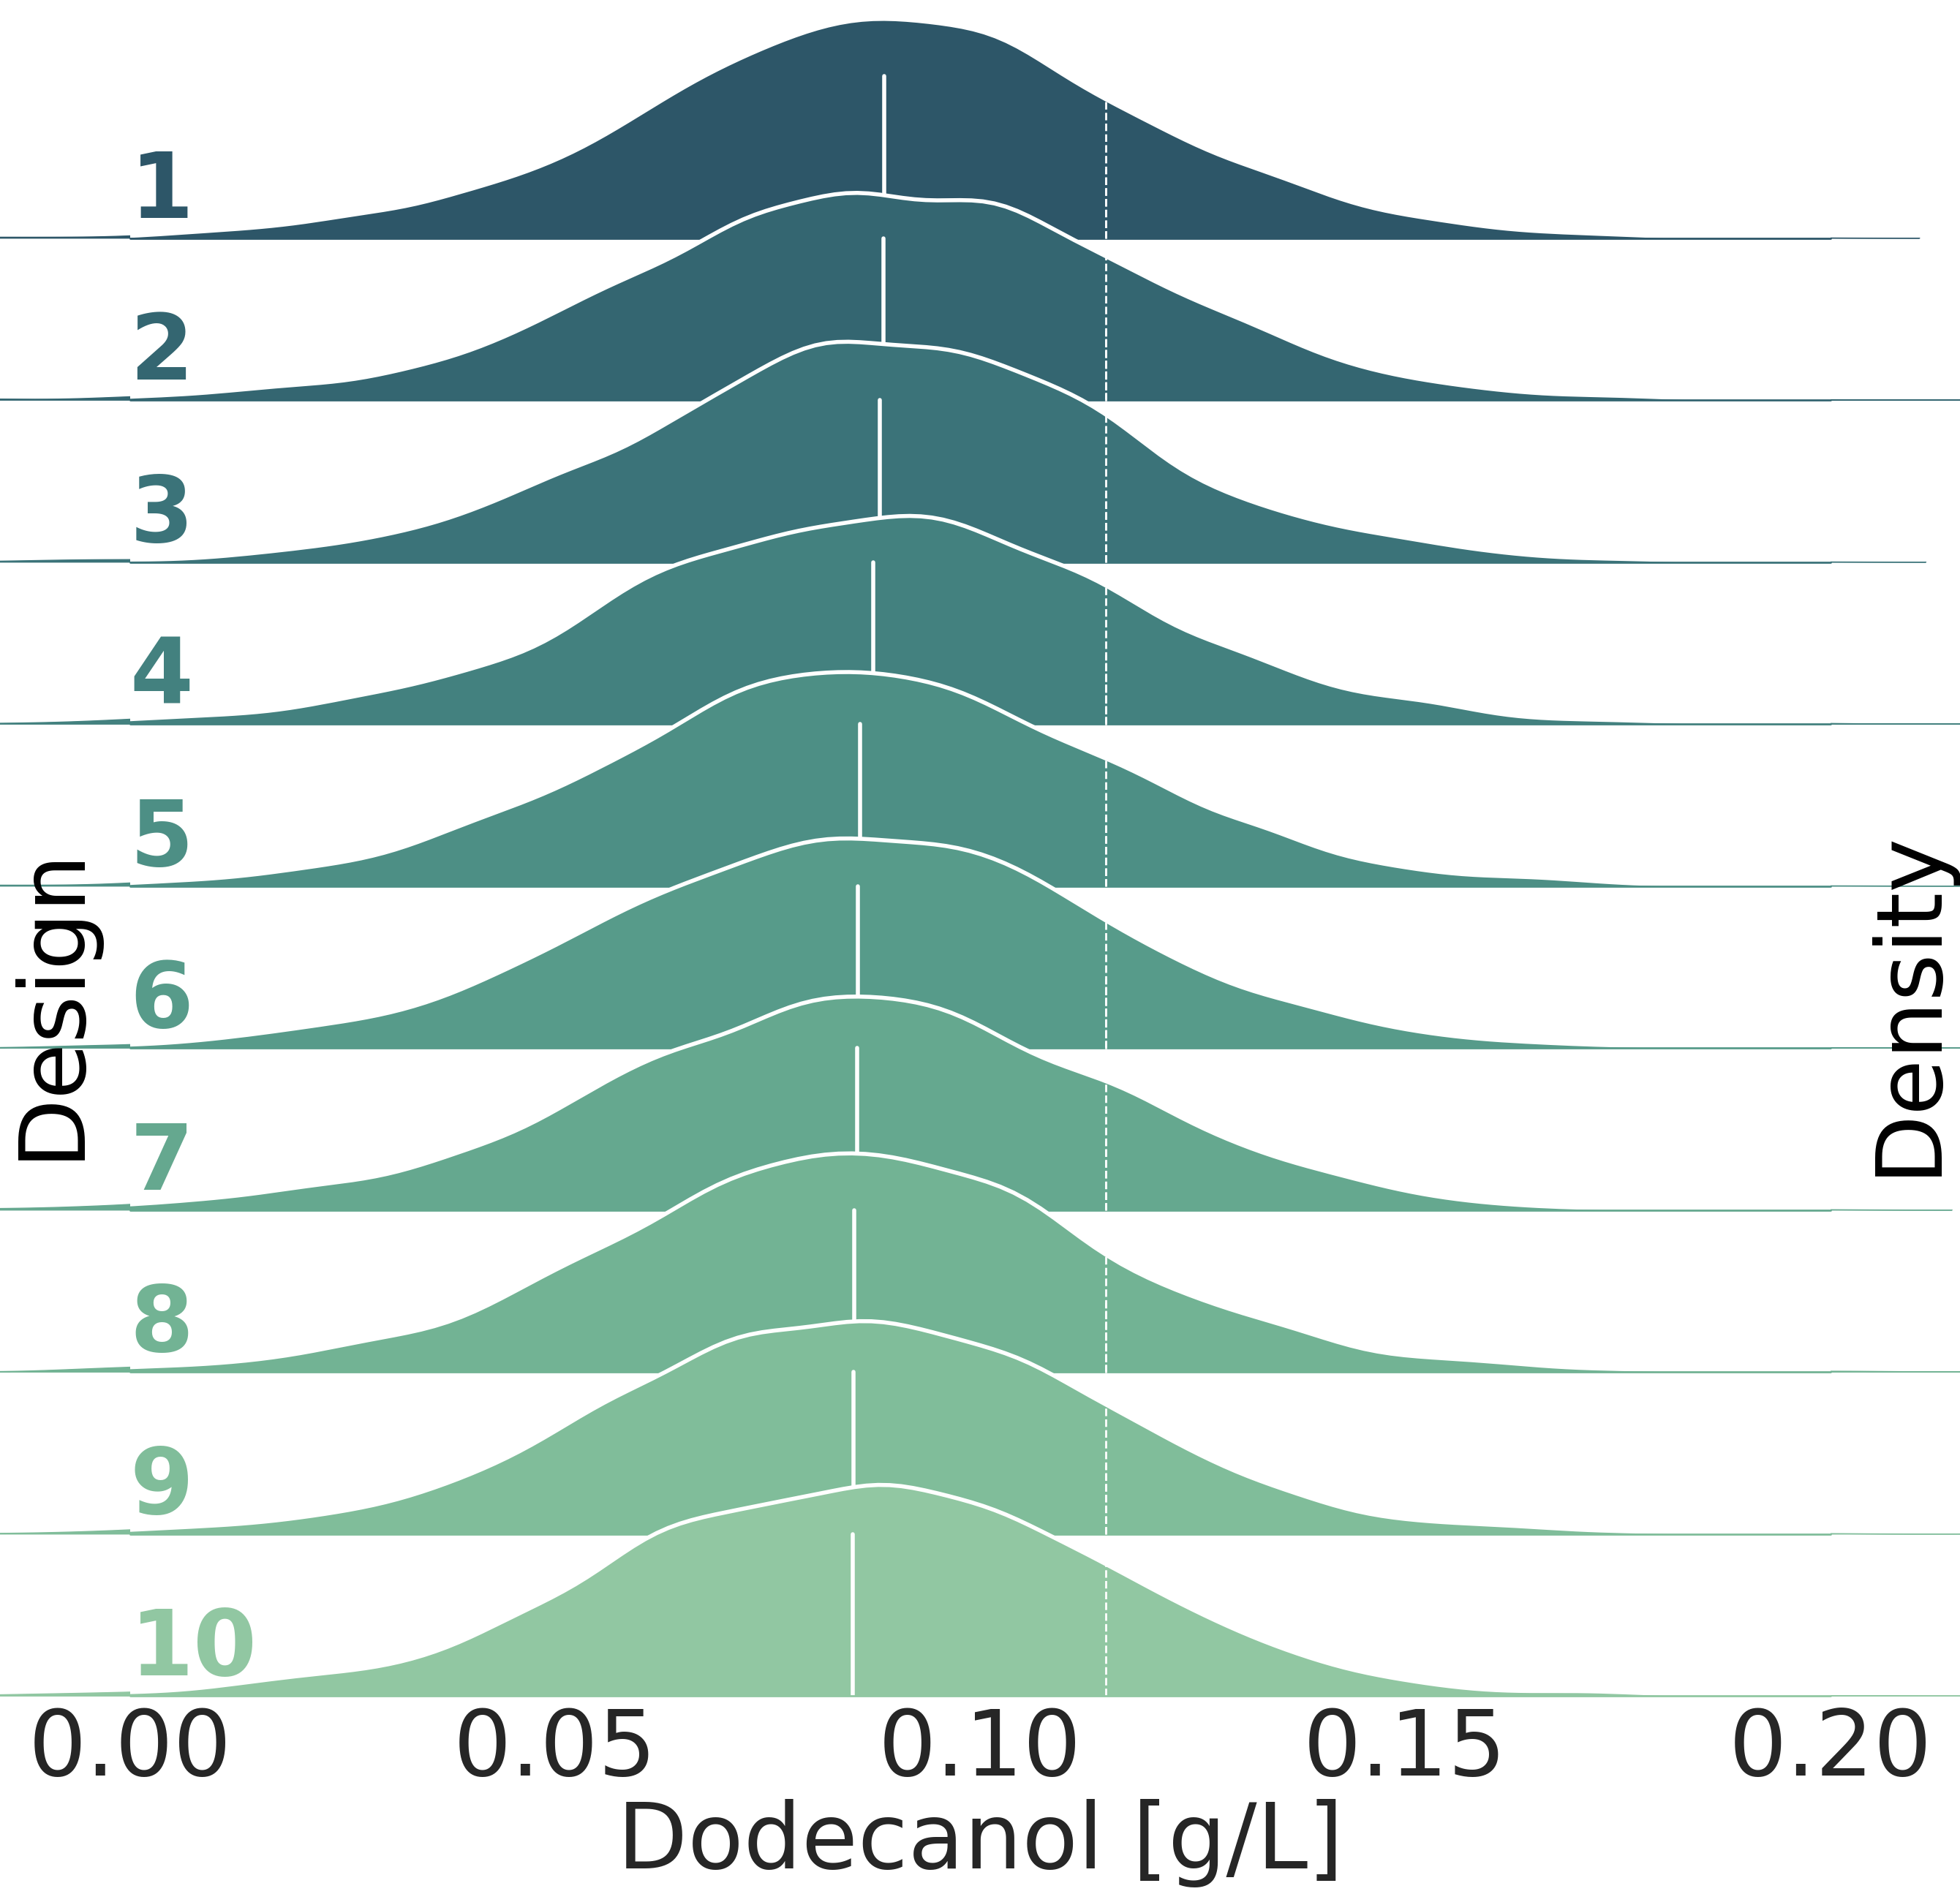

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.70 s
Done computing success probabilities in 0.70 s


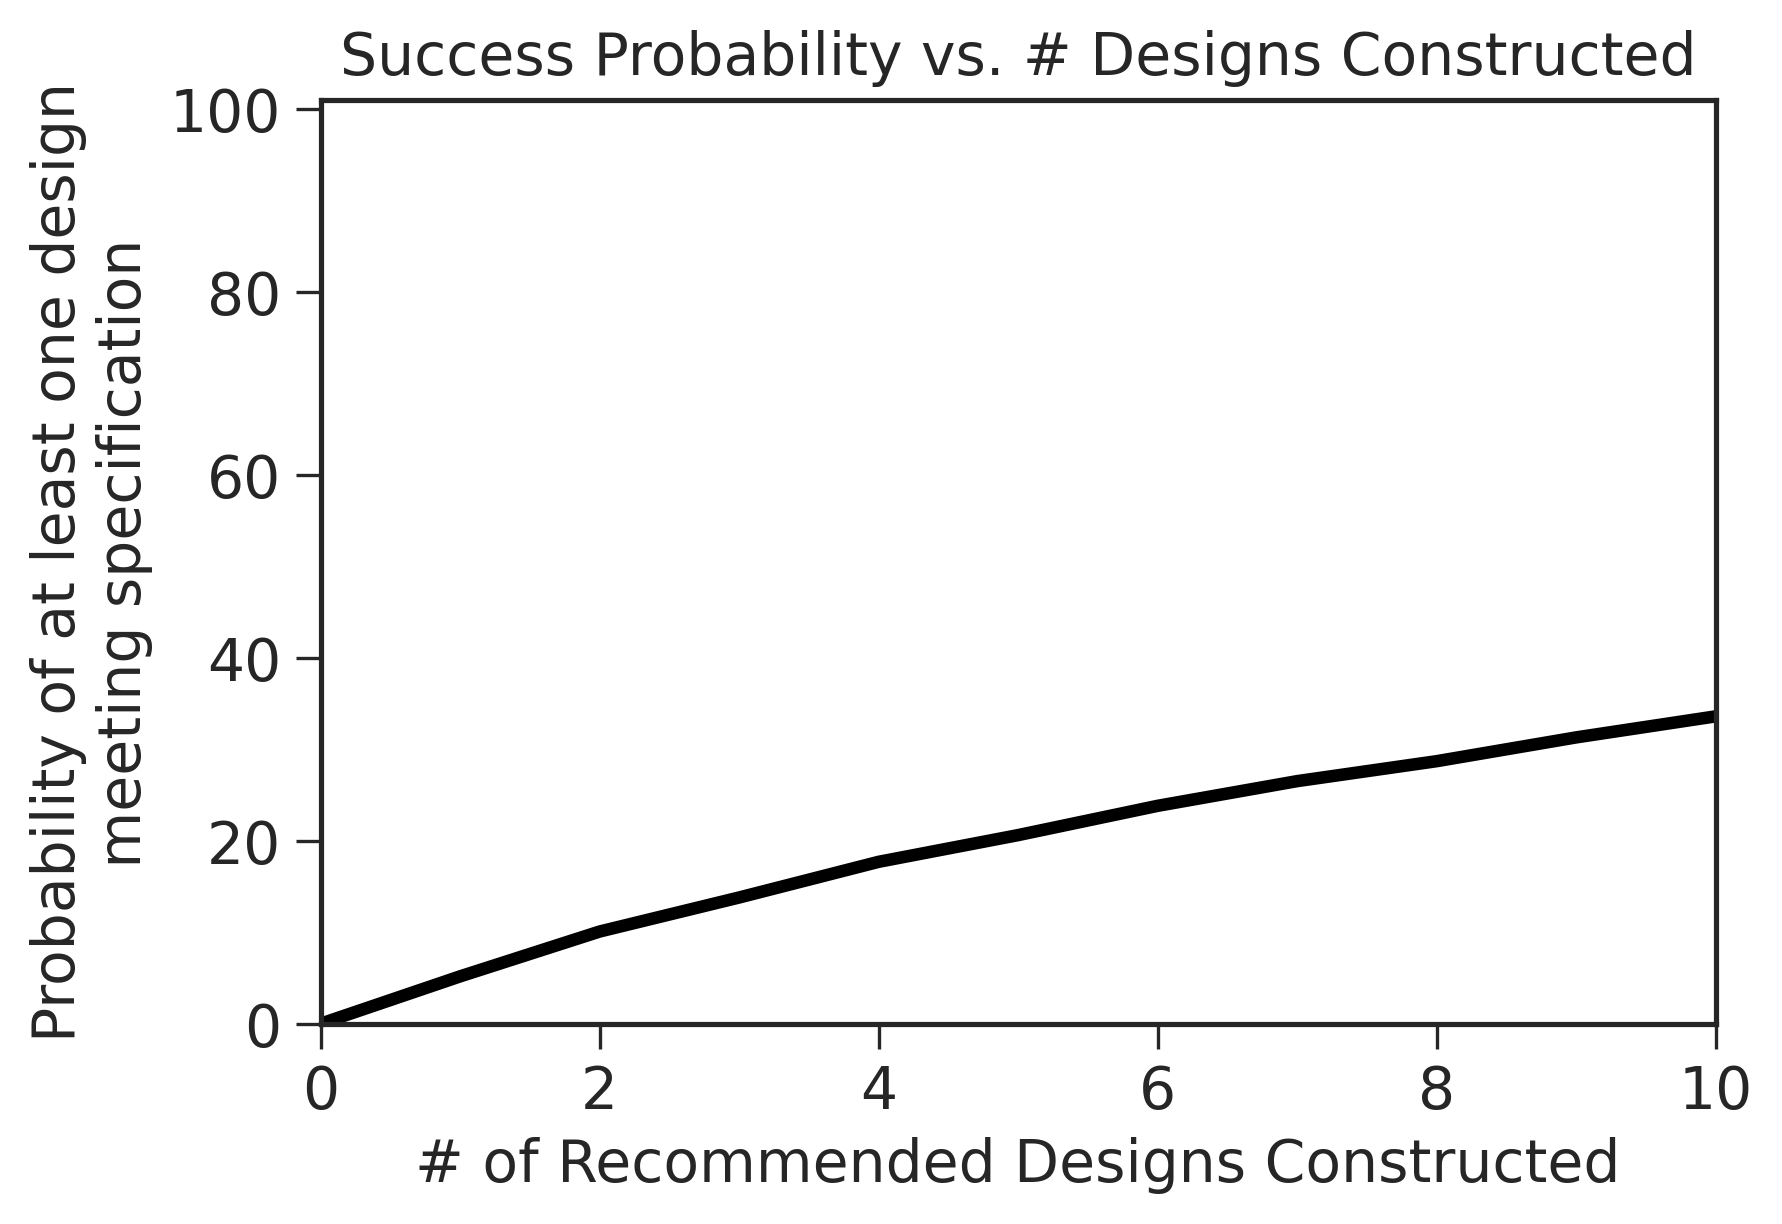

In [19]:
plot.recomm_distribution(art, ['Dodecanol [g/L]'],[0,0.2])
cum_success_prob = art.compute_success_prob(current_best=art.find_current_best())
plot.success_prob(art, cum_success_prob)

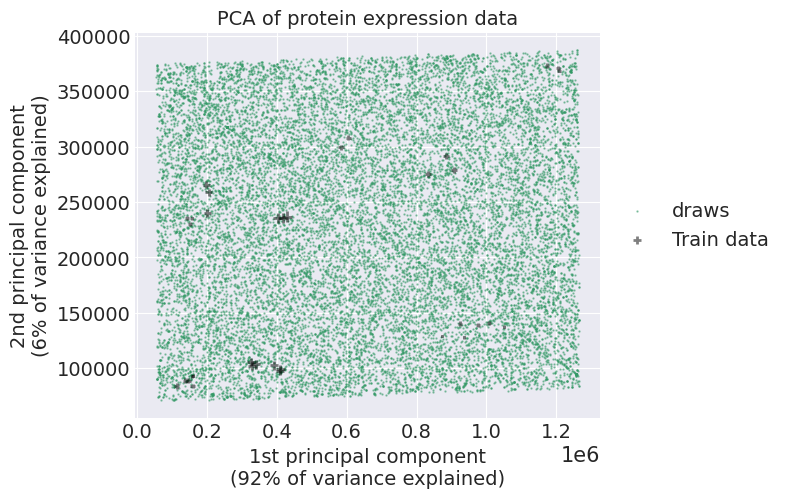

In [20]:
plot.draws_pc(art, draws, plot_scale_factor=500, plot_draws=True, plot_kde=False)

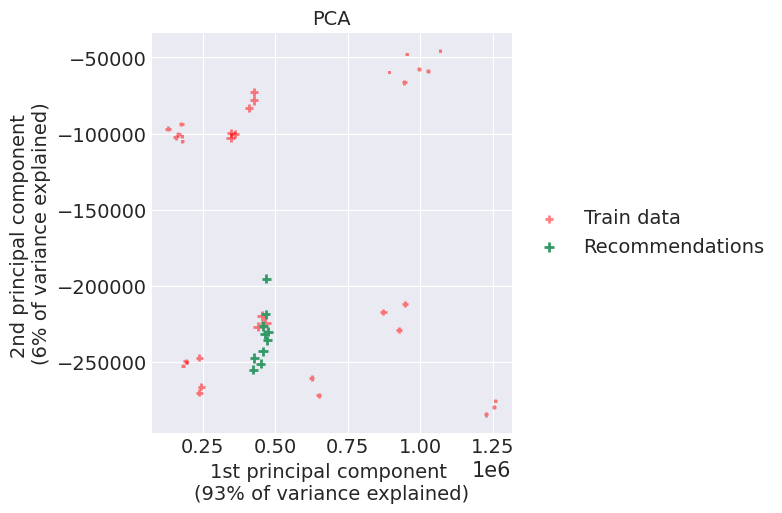

In [21]:
plot.recommendations_pc(art, plot_scale_factor=500)

In [22]:
art.save()